# Corona Virus Analysis (Covid-19)
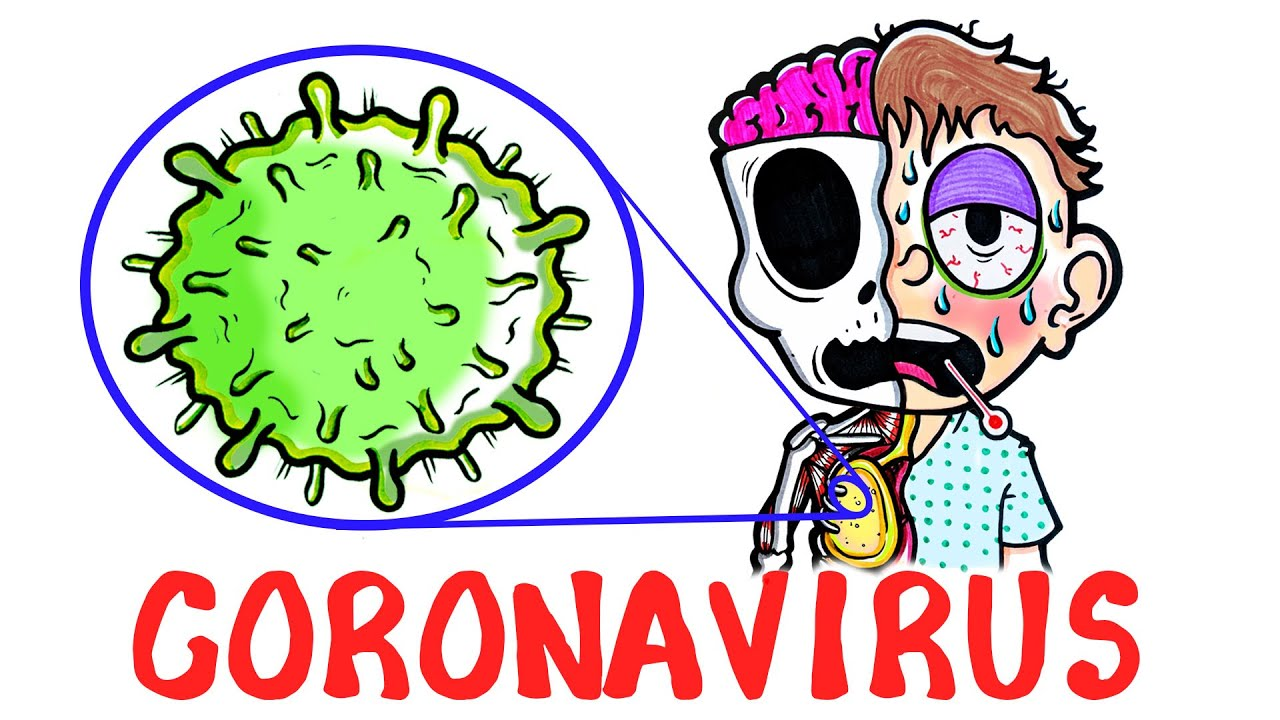

### Importing Required Libraries

In [697]:
import requests
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from shapely.geometry import Point, Polygon

#### Fetching data using API from Govt of India Server

In [5]:
api_link = requests.get('https://api.covid19india.org/data.json')

In [13]:
json_data = api_link.json()

In [14]:
list(api_link.json())

['cases_time_series', 'statewise', 'tested']

In [773]:
df = pd.DataFrame(json_data['statewise'])
df.head()

,active,confirmed,deaths,deltaconfirmed,deltadeaths,deltarecovered,lastupdatedtime,recovered,state,statecode,statenotes
0,52970,86508,2760,652,7,528,16/05/2020 14:13:23,30773,Total,TT,
1,21468,29100,1068,0,0,0,15/05/2020 20:43:24,6564,Maharashtra,MH,[10-May]<br>\n- Total numbers are updated to t...
2,7438,10108,71,0,0,0,15/05/2020 23:22:24,2599,Tamil Nadu,TN,
3,5291,9932,606,0,0,0,15/05/2020 20:53:24,4035,Gujarat,GJ,
4,5278,9333,129,438,6,408,16/05/2020 14:13:23,3926,Delhi,DL,[10-May]<br>\n\nDelhi will be releasing bullet...


#### As there are some variables which are integers but are not in INT format 
- Let's convert them

In [774]:
integer_columns = ['active','confirmed','deaths','deltaconfirmed','deltadeaths','deltarecovered','recovered']
df[integer_columns] = df[integer_columns].apply(pd.to_numeric) 

In [775]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38 entries, 0 to 37
Data columns (total 11 columns):
active             38 non-null int64
confirmed          38 non-null int64
deaths             38 non-null int64
deltaconfirmed     38 non-null int64
deltadeaths        38 non-null int64
deltarecovered     38 non-null int64
lastupdatedtime    38 non-null object
recovered          38 non-null int64
state              38 non-null object
statecode          38 non-null object
statenotes         38 non-null object
dtypes: int64(7), object(4)
memory usage: 3.4+ KB


##### Removing the complete timestamp, as I am not doing any Time Series Analysis

In [776]:
#pd.to_datetime(df['lastupdatedtime'], dayfirst=True).dt.strftime('%Y-%m-%d')   
#df['lastupdatedtime'] = pd.to_datetime(df['lastupdatedtime'], format='%d/%m/%Y %H:%M:%S').dt.strftime('%d %B')
df['lastupdatedtime'] = pd.to_datetime(df['lastupdatedtime'], format='%d/%m/%Y %H:%M:%S').dt.strftime('%Y-%m-%d') 

In [777]:
df['statenotes'].iloc[1]

'[10-May]<br>\n- Total numbers are updated to the final figure reported for 10th May. <br>\n- 665 cases added by MH govt. on 10th May due to data cleaning <br>\n- 143 cases added by MH govt. on 5th May due to data cleaning <br>\n- 796 cases added by MH govt. on 4th May due to data cleaning <br>'

#### Dropping 'statenotes' variable, as I am not doing any NLP here

In [778]:
df.drop('statenotes',axis=1,inplace=True)

#### Fetching Unique List of all the states
- There are 36 states in India incuding UT's
- Here, 1 extra is for TOTAL and 1 extra for separate 'Daman and Diu'

In [779]:
#df['state'].value_counts().sort_index(ascending=False).sort_values(ascending=False)
df['state'].value_counts().index.sort_values()   # 1 extra for TOTAL and 1 extra for separate 'Daman and Diu'

Index(['Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh',
       'Assam', 'Bihar', 'Chandigarh', 'Chhattisgarh',
       'Dadra and Nagar Haveli and Daman and Diu', 'Daman and Diu', 'Delhi',
       'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jammu and Kashmir',
       'Jharkhand', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep',
       'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
       'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Rajasthan', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Total', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal'],
      dtype='object')

In [780]:
all_states =  df['state'].value_counts().index.sort_values()
f'In our dataset, we have total of {len(all_states)} States including UTs '

'In our dataset, we have total of 38 States including UTs '

#### Contribution of each state to this Pandemic within India 

In [784]:
#df['confirmed'][df['state']=='Total']  # Avoid using this 
total_cases = df['confirmed'][0]
f'Total No. of cases in India are : {total_cases}'

'Total No. of cases in India are : 86508'

In [785]:
corona_free_states = df['state'][df['confirmed'].divide(df['confirmed'][0])==0]
free_states = [f for f in corona_free_states]
print(f'Congratulations, following {len(free_states)} states are now Corona Free : \n {free_states}')

Congratulations, following 4 states are now Corona Free : 
 ['Nagaland', 'Daman and Diu', 'Lakshadweep', 'Sikkim']


In [786]:
def top_contributors(dataframe,column_name):
    df2=dataframe[['state',column_name]]
    fig=plt.style.use('ggplot')
    df2.groupby(['state']).sum().sort_values(by=[column_name], ascending=False)[1:].plot(kind='bar',figsize=(16,6))
    plt.ylabel(f'{column_name.title()} Cases')

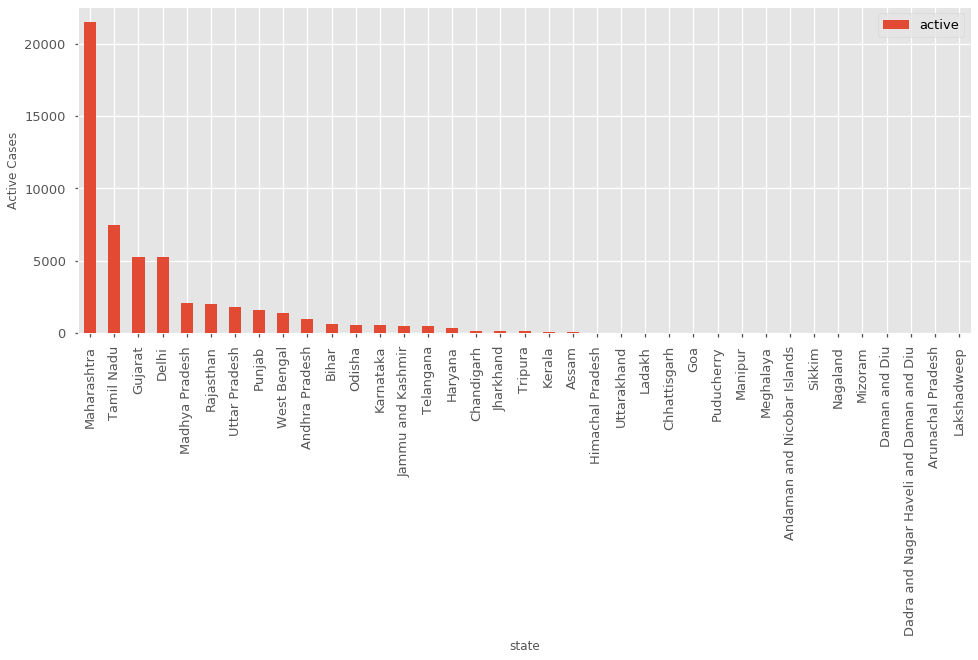

In [787]:
top_contributors(df,'active')

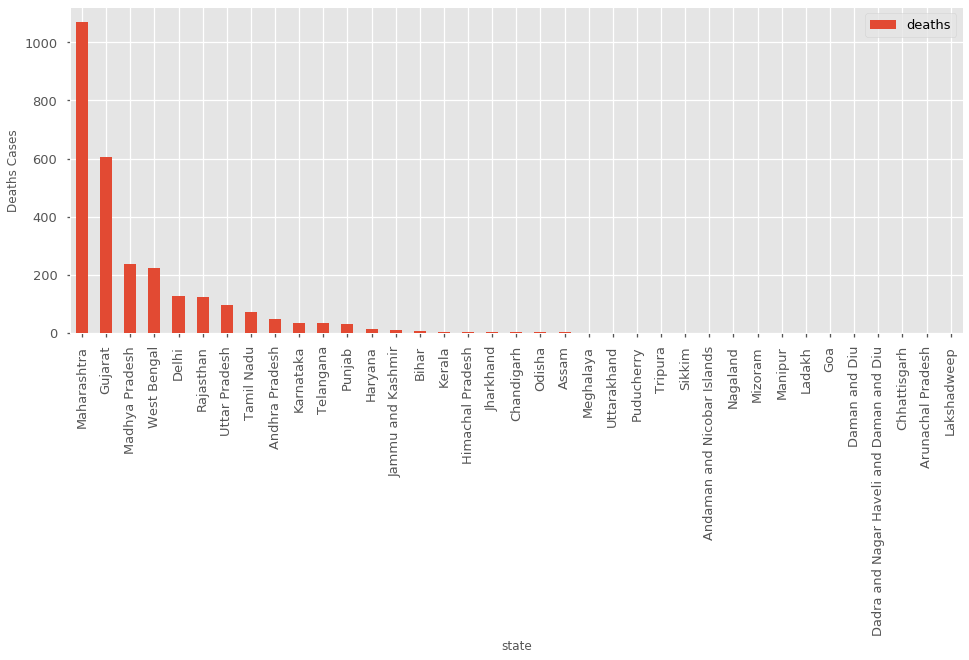

In [788]:
top_contributors(df,'deaths')

### Plotting the distribution of Active Cases on Indian Map
- To achieve this, we will require latitude and longitude of each state
- To plot them on map, we need to point those cordinates to Map Pointers
- We will load the data (Lat and Long) from .csv file and Map them with our dataset
- For the values that are mismatch, we will hardcode the values

In [789]:
lat_long_df = pd.read_csv('India_lat_long.csv', usecols = ['admin','lat','lng'])
lat_long_df = lat_long_df.drop_duplicates(subset=['admin'])
lat_long_df['state'] = [unidecode(i) for i in lat_long_df['admin']]
lat_long_df.drop('admin',axis=1,inplace=True)
lat_long_df.head()

,lat,lng,state
0,18.987807,72.836447,Maharashtra
1,28.651952,77.231495,Delhi
2,22.562627,88.363044,West Bengal
3,13.084622,80.248357,Tamil Nadu
4,12.977063,77.587106,Karnataka


In [790]:
df = pd.merge(df, lat_long_df , on=['state'], how='left')
df.rename(columns={'lat': 'latitude', 'lng': 'longitude'}, inplace=True)

In [791]:
df[df['latitude'].isnull()]    # For these 4 States, we need to hardcode values 

,active,confirmed,deaths,deltaconfirmed,deltadeaths,deltarecovered,lastupdatedtime,recovered,state,statecode,latitude,longitude
0,52970,86508,2760,652,7,528,2020-05-16,30773,Total,TT,NaN,NaN
2,7438,10108,71,0,0,0,2020-05-15,2599,Tamil Nadu,TN,NaN,NaN
11,461,1454,34,0,0,0,2020-05-15,959,Telangana,TG,NaN,NaN
25,19,43,0,0,0,0,2020-05-15,24,Ladakh,LA,NaN,NaN
33,0,1,0,0,0,0,2020-05-12,1,Dadra and Nagar Haveli and Daman and Diu,DN,NaN,NaN


In [792]:
df.loc[2, 'latitude']=1.1271
df.loc[11,'latitude']=18.1124
df.loc[25,'latitude']=34.152588
df.loc[33,'latitude']=20.4283
df.loc[0,'latitude']=20.5937

df.loc[2, 'longitude']=78.6569
df.loc[11,'longitude']=79.0193
df.loc[25,'longitude']=77.577049
df.loc[33,'longitude']=72.8397
df.loc[0,'longitude']=78.9629

In [797]:
df['longitude'].isnull().sum()

0

In [798]:
df['coordinates'] = list(zip(df['latitude'], df['longitude']))   # Combining Lat and Longs in the form of Tuple 

/Users/heisenberg/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning:

'+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6



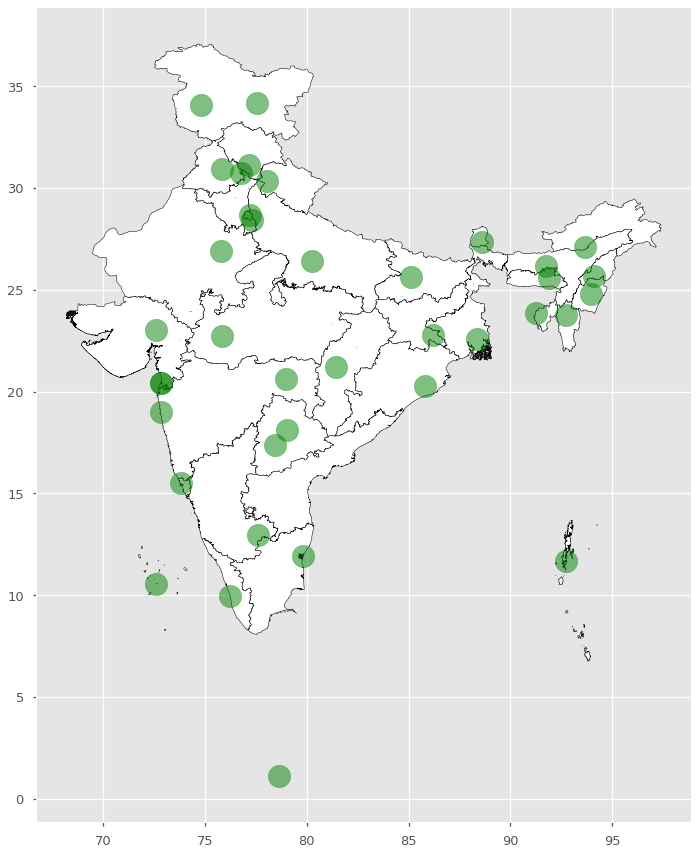

In [799]:
geometry = [Point(x[1], x[0]) for x in df['coordinates']]
geographical_df = gpd.GeoDataFrame(df['active'], crs = {'init': 'epsg:4326'}, geometry=geometry) # crs is coordinate system 
plt.figsize=(50, 50)
india_coordinates =  gpd.read_file('Indian_map/Indian_States.shp')
ax = india_coordinates.plot(color='white', edgecolor='black', figsize=(50, 15))
geographical_df.plot(ax=ax, color='green', markersize = 500, alpha=0.5)
plt.show()

### Stacked Bar Graph to see how states are performing in every aspect 

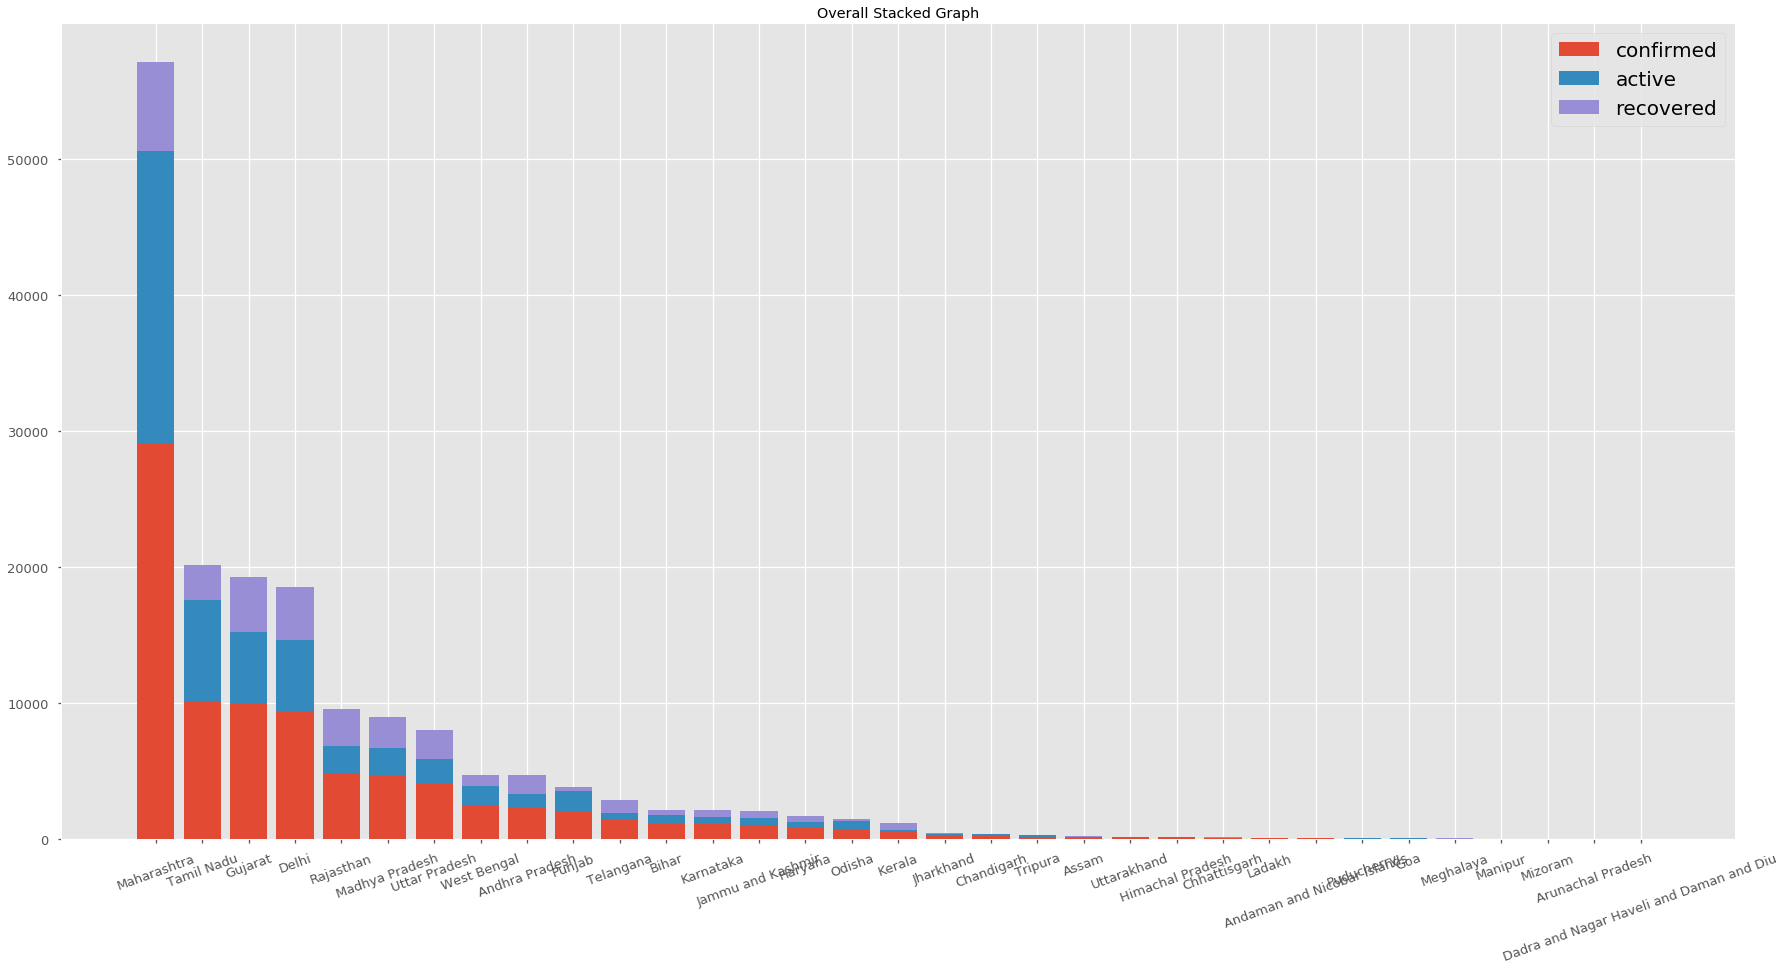

In [800]:
stacked_df = df_select[['state','confirmed','active','recovered']]

cumval=0
fig = plt.figure(figsize=(30,15))
for col in stacked_df.columns[~stacked_df.columns.isin(['state'])]:
    plt.bar(stacked_df.state, stacked_df[col], bottom=cumval, label=col)
    cumval = cumval+stacked_df[col]
plt.xticks(rotation=20)
plt.title("Overall Stacked Graph")
plt.legend(fontsize=20)

#### Percentage of Each state contribution in Corona Pandemic
- As there are some states, which are now Corona Free, so we won't take them in our Analysis.

In [801]:
df['total_corona_contribution'] = df['confirmed'].divide(df['confirmed'][0])*100

In [802]:
df = df[~df['state'].isin(free_states)]

In [388]:
integer_columns = ['active','confirmed','deaths','deltaconfirmed','deltadeaths','deltarecovered','recovered','total_corona_contribution']

df[integer_columns] = df[integer_columns].apply(pd.to_numeric) 

### Building another dataset , so as to make our Analysis easy and fast, we will find 
- Active rate of cases within that state
- Death rate within that state
- And, Recovery rate within that state

In [806]:
df_select = df[['state','confirmed','active','deaths','recovered','total_corona_contribution']].sort_values(['confirmed'], ascending=[False])[1:]

In [807]:
active_rate = round(df_select['active']/df_select['confirmed'],2)*100
death_rate = round(df_select['deaths']/df_select['confirmed'],2)*100
recovery_rate = round(df_select['recovered']/df_select['confirmed'],2)*100

df_select['active_rate'] = active_rate
df_select['death_rate'] = death_rate
df_select['recovery_rate'] = recovery_rate

In [808]:
df_select.head()

,state,confirmed,active,deaths,recovered,total_corona_contribution,active_rate,death_rate,recovery_rate
1,Maharashtra,29100,21468,1068,6564,33.638507,74.0,4.0,23.0
2,Tamil Nadu,10108,7438,71,2599,11.684468,74.0,1.0,26.0
3,Gujarat,9932,5291,606,4035,11.481019,53.0,6.0,41.0
4,Delhi,9333,5278,129,3926,10.788598,57.0,1.0,42.0
6,Rajasthan,4838,1979,125,2734,5.592546,41.0,3.0,57.0


In [829]:
def top_5_states_maps(dataframe, column_name, no_of_states):
    
    if column_name == 'confirmed' :  #not in ['active','deaths','recovered']:
        labels = [i for i in dataframe['state'][:no_of_states]]
        values = [i for i in dataframe[column_name][:no_of_states]]
        plt.style.use("seaborn-talk")
        wedge_dict = {'edgecolor': 'black','linewidth': 2}
        explode = (0.1, 0, 0, 0, 0)
        plt.title(f"Within top {no_of_states} States, contribution of each state in Corona")
        plt.pie(values, labels=labels, explode=explode, autopct='%1.1f%%', wedgeprops=wedge_dict)
        plt.show()
    else:
        df_tempo = dataframe[['state',column_name]].sort_values([column_name], ascending=[False])
        free_state = df_tempo['state'][df_tempo[column_name]==100]
        free_state = [i for i in free_state ]
        
        if len(free_state) > 0 :
            print(f'These {len(free_state)} states has 100% {column_name} \n \n {free_state}')
        else :
            print(f'No state has observed 100* {column_name.title()}')

        df_temp = df_tempo[df_tempo[column_name]<100][:no_of_states]
        labels = [i for i in df_temp['state'][:no_of_states]]
        values = [i for i in df_temp[column_name][:no_of_states]]
        plt.style.use("seaborn-talk")
        wedge_dict = {'edgecolor': 'black','linewidth': 2}
        explode = (0.1, 0, 0, 0, 0)
        plt.title(f"Within top {no_of_states} States, {column_name.title()} contribution of each state in Corona")
        plt.pie(values, labels=labels, explode=explode, autopct='%1.1f%%', wedgeprops=wedge_dict)
        return plt.show()
        

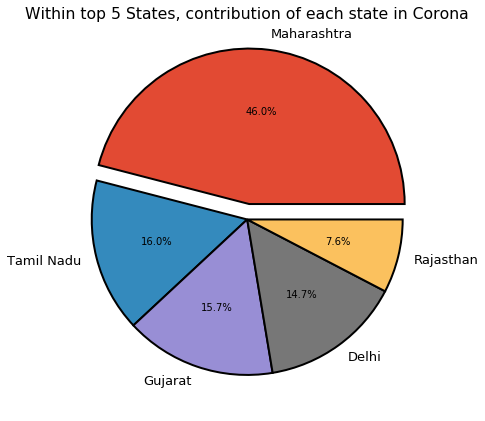

In [824]:
top_5_states_maps(df_select,'confirmed',5)

No state has observed 100* Active_Rate


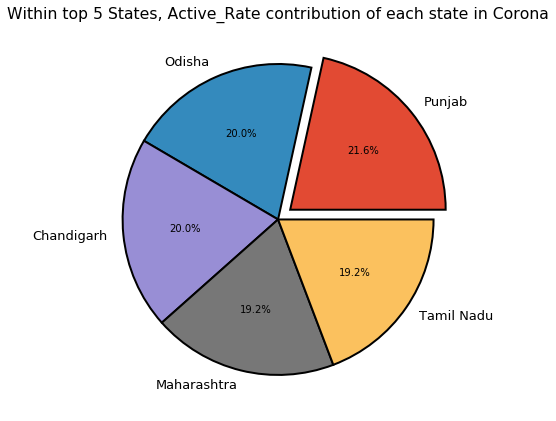

In [825]:
top_5_states_maps(df_select,'active_rate',5)

No state has observed 100* Death_Rate


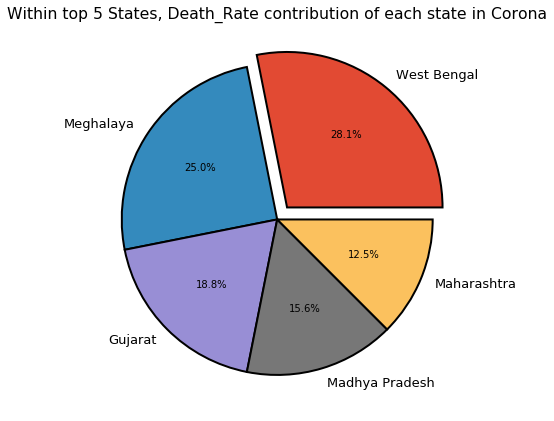

In [835]:
top_5_states_maps(df_select,'death_rate',5)

These 4 states has 100% recovery_rate 
 
 ['Dadra and Nagar Haveli and Daman and Diu', 'Arunachal Pradesh', 'Mizoram', 'Andaman and Nicobar Islands']


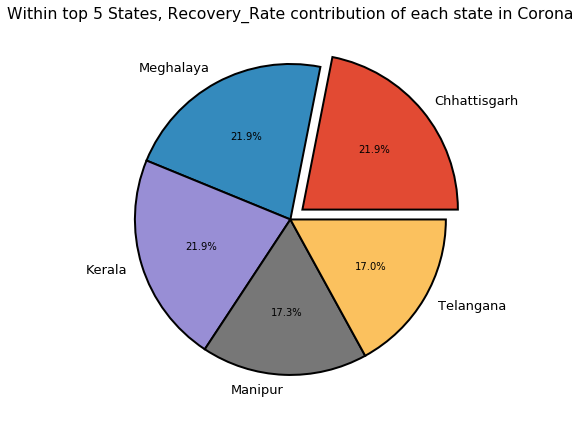

In [827]:
top_5_states_maps(df_select,'recovery_rate',5)